# Sorter Baseline

In [1]:
import os
from datasets import load_dataset
from PIL import Image
import itertools
from transformers import ViltProcessor

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
!export CUDA_VISIBLE_DEVICES='0'

import torch
torch.cuda.device_count()

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria

from PIL import Image

import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer
import json
import numpy as np

/data/vkarlov/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-15 15:38:51.580044: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 15:38:51.628744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 15:38:52.588969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tensor

In [2]:
from dataclasses import dataclass, field
from torch.utils.data import Dataset

## Датасет

In [3]:
from typing import List

@dataclass
class Step:
    action: str = ""
    text: str = ""
    arguments: List[str] = field(default_factory=list)

@dataclass
class SorterTask():
    action: str = ""
    image: str = ""
    text: str = ""
    goal: str = ""
    text: str = ""
    task_type: int = -1
    plan_id: int = -1
    steps: List[Step] = field(default_factory=list)
    arguments: List[str] = field(default_factory=list)

    def to_list(self):
        return [[step.action, [arg for arg in step.arguments]] for step in self.steps]

class SorterDataset(Dataset):
    def __init__(self, path_to_csv: str = ""):
        with open(path_to_csv, 'r') as f:
            self._data = json.load(f)
        self._size = len(self._data)

    def __len__(self):
        return self._size

    def __getitem__(self, idx) -> SorterTask:
        entry = self._data[idx]
        steps = []
        for plan in entry['plan']:
            steps.append(Step(action=plan[0],
                              arguments=plan[1]))
        return SorterTask(goal=entry['goal_eng'],
                        image='/data/vkarlov/robotics/train_dataset/train_images/' + entry['image'],
                        # image='/data/vkarlov/robotics/train_dataset/train_images/' + "1808600344675605482_0.png",
                        steps=steps,
                        task_type=entry['task_type'],
                        plan_id=entry["plan_id"])    

## Модель

In [4]:
import torch
import torch.nn.functional as F

from tqdm import tqdm
from transformers import AutoModelForCausalLM, LlamaTokenizer
from transformers import pipeline
from typing import Any, List, Optional


@dataclass
class BaseInput:
    text: Optional[str] = None
    

@dataclass
class BaseOutput:
    text: Optional[str] = None

In [5]:
model_path = "liuhaotian/llava-v1.5-7b"
conv_mode = 'llava_v1'

In [6]:
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None, 
    model_name=model_name, 
    load_8bit=True,
    load_4bit=False)

Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.05s/it]
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [7]:
if 'llama-2' in model_name.lower():
    conv_mode = "llava_llama_2"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

if conv_mode is not None and conv_mode != conv_mode:
    print('[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}'.format(conv_mode, conv_mode, conv_mode))
else:
    conv_mode = conv_mode

In [8]:
SYSTEM = \
'''
You are helpful robot operating in a house. You should tell me the sequence of actions you would do to accomplish my task. Important you are also given an image with your initial position and what you have in your arm, take this information into account. You have 3 possible actions: "pick_up(from, what)", "move_to(where, what)" and "put(where, what)". At the end of sequence you should write "done()".
If the location (where/from) or object(what) are not specified, you should write "unspecified" as action parameter.

Examples:
Picture: Vegetables, a cube on the table and a bedside table.
Request: How would you drive up to the bedside table?
Answer: 1. move_to("bedside table", "unspecified"), 2. done().

Picture: Robot with cat in the manipulator arm.
Request: How would you put the gray cat in the orange box?
Answer: 1. move_to("orange box", "gray cat"), 2. put("orange box", "gray cat"), 3. done().

Picture: Table with vegetables, bedside table and robot with empty manipulation arm. 
Request: How would you take a cucumber from the table and put it in an orange box?
Answer: 1. move_to("table", "cucumber"), 2. pick_up("table", "cucumber"), 3. move_to("orange box", "cucumber"), 4. put("orange box", "cucumber"), 5. done().

Picture: Orange kitten and robot with empty manipulation arm.
Request: How would you put the orange kitten in the green box?
Answer: 1. move_to("unspecified", "orange kitten"), 2. pick_up("unspecified", "orange kitten"), 3. move_to("green box", "orange kitten"), 4. put("green box", "orange kitten"), 5. done().

Picture: Green container and robot with toy cat in the manipulation arm.
Request: How would you put the toy cat in the green container?
Answer: 1. move_to("green container", "toy cat"), 2. put("green container", "toy cat"), 3. done().

Picture: Green container and orange container in the distance and robot with toy cat in the manipulation arm.
Request: How would you put the kitten down on the floor?
Answer: 1. put("floor", "kitten"), 2. done().
'''

In [9]:
def load_image(image_file):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

def preprocess_text_to_inp_ids(req):
    inp = f"Request: How whould you {req.lower()[:-1]}?\nAnswer:"
    inp = SYSTEM + inp
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').cuda()
    # print(input_ids.shape)
    # print(prompt)
    return input_ids

def pad_ids(input_ids, max_batch_len):
    p1d = (max_batch_len - len(input_ids), 0)
    return F.pad(input_ids, p1d, "constant", 0)

def create_att_mask(input_ids, max_batch_len):
    return torch.cat((
        torch.zeros(max_batch_len - len(input_ids)), torch.ones(len(input_ids))
        ))

def infer_model(batch):
    batch_images = [load_image(elem.image) for elem in batch]
    image_tensors = image_processor.preprocess(batch_images, return_tensors='pt')['pixel_values'].half().cuda()
    # print(image_tensors)
    batch_input_ids = [preprocess_text_to_inp_ids(elem.goal) for elem in batch]
    max_batch_len = np.max([len(ids) for ids in batch_input_ids])
    batch_att_masks = [create_att_mask(ids, max_batch_len) for ids in batch_input_ids]
    batch_input_ids = [pad_ids(ids, max_batch_len) for ids in batch_input_ids]
    # print(batch_att_masks[0])
    # print(batch_input_ids[0])
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles

    # print(prompt)
    # print('-' * 100)

    # stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    # keywords = [stop_str]
    # stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, batch_input_ids[0])
    # streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids=torch.stack(batch_input_ids),
            attention_mask=torch.stack(batch_att_masks),
            images=image_tensors,
            do_sample=True,
            temperature=0.2,
            max_new_tokens=256,
            # streamer=streamer,
            use_cache=True,
            # stopping_criteria=[stopping_criteria]
            )

    return [tokenizer.decode(output_ids[i, batch_input_ids[i].shape[0]:], skip_special_tokens=True).strip() for i in range(len(batch))]


## Работа с промптом

In [10]:
import re
from typing import List, Optional, Union

class PromptProcessor():
    def __init__(self, **kwargs) -> None:
        self.TERMINATING_STRING = 'done()'
        self._system_prompt = ""
        self._stop_step_pattern = ""
        self._stop_pattern = re.compile(f'\\d+\\. {self.TERMINATING_STRING}.')

    @property
    def system_prompt_is_set(self) -> bool:
        return len(self._system_prompt) > 0

    def is_terminating(self, step: Step) -> bool:
        return step.text == self.TERMINATING_STRING

    def build_system_prompt(self, example_tasks: List[SorterTask]) -> str:
        prompt = "Robot: Hi there, I’m a robot operating in a house.\n"
        prompt += "Robot: You can ask me to do various tasks and "
        prompt += "I’ll tell you the sequence of actions I would do to accomplish your task.\n"

        for task in example_tasks:
            prompt += self._task_to_prompt(task) + '\n'

        self._system_prompt = prompt
        self._stop_step_pattern = re.compile(
            r'(\s*\d+\.\s*)(\w+\(("[\w ]+"(,\s)?)*\))*')

    def load_prompt_from_file(self, filepath: str) -> None:
        with open(filepath, 'r') as file:
            self._system_prompt = file.read()
        self._stop_step_pattern = re.compile(
            r'(\s*\d+\.\s*)(\w+\(("[\w ]+"(,\s)?)*\))*')

    def _goal_to_query(self, goal: str) -> str:
        query = f"Human: How would you {goal.lower()}?\n"
        query += f'Robot: '
        return query

    def _step_to_text(self, step: Step) -> str:
        arguments = [f'"{argument}"' for argument in step.arguments]
        text = f'{step.action}({", ".join(arguments)})'
        return text

    def _steps_to_text(self,
                       steps: List[Step],
                       add_terminating_string: bool = True) -> str:
        text = ", ".join([f'{step_idx}. {self._step_to_text(step)}'
                          for step_idx, step in enumerate(steps, start=1)])
        if add_terminating_string:
            text += f", {len(steps) + 1}. {self.TERMINATING_STRING}."
        return text

    def _task_to_prompt(self, task: SorterTask) -> str:
        prompt = self._goal_to_query(task.goal)
        text = self._steps_to_text(task.steps)
        task.text = text
        prompt += text
        return prompt

    def to_inputs(self,
                  task: SorterTask,
                  steps: Optional[List[Step]] = None,
                  options: Optional[List[Step]] = None) -> BaseInput:
        if not self.system_prompt_is_set:
            raise ValueError(
                "System prompt is not set. You need to set system prompt.")
        else:
            text = self._system_prompt + self._goal_to_query(task.goal)
            if steps is not None:
                text += self._steps_to_text(steps, add_terminating_string=False)
            if options is not None:
                return ScoringInput(text=text, options=[f'{len(steps) + 1}. {option.text}' for option in options])
            return BaseInput(text=text)

    def _text_to_steps(self, task_text: str, cut_one_step: bool = False) -> Union[List[Step], Step, None]:
        self._stop_step_pattern = re.compile(r'(\s*\d+\.\s*)(\w+\(("[\w ]+"(,\s)?)*\))*')

        if cut_one_step:
            stop_match = self._stop_step_pattern.match(task_text)
            if stop_match is None:
                return None
            else:
                return self._parse_action(stop_match.group(2))
        else:
            stop_match = self._stop_step_pattern.findall(task_text)
            steps = []
            if stop_match is None:
                return steps
            else:
                for i in range(len(stop_match) - 1):
                    step_text = stop_match[i][1]
                    step = self._parse_action(step_text)
                    if step is not None:
                        steps.append(step)
                return steps

    def _parse_action(self, step_text: str) -> Optional[Step]:
        """ Parse action with arguments to step.
        text: put_on('pepper', 'white box')
        action: put_on
        arguments: ['pepper', 'white box']
        """
        step_decomposition_pattern = re.compile(r'\s*([A-Za-z_][A-Za-z_\s]+)')
        arguments = step_decomposition_pattern.findall(step_text)

        if arguments is None:
            return None
        if len(arguments) == 1:
            step = Step(text=step_text)
        else:
            step = Step(action=arguments[0],
                        arguments=arguments[1:],
                        text=step_text)
            return step

    def to_task(self, task: BaseOutput) -> SorterTask:
        # Full plan generation mode
        stop_match = self._stop_pattern.search(task.text)

        if stop_match is not None:
            task.text = task.text[:stop_match.end() + 2].strip(' \n\t')
        else:
            task.text = task.text.strip(' \n\t')

        steps = self._text_to_steps(task_text=task.text)

        return SorterTask(text=task.text, steps=steps)

## Генерация плана

In [11]:
from typing import List

class FullPlanGeneration():
    def __init__(self,
                 model,
                 processor,
                 **kwargs):
        self._processor = processor
        self._model = model

    def predict(self, gt_task_batch: List[SorterTask]) -> List[SorterTask]:
        batch_outputs = infer_model(gt_task_batch)
        model_ouputs = [self._processor.to_task(BaseOutput(text.replace('\\', ''))) for text in batch_outputs]
        return model_ouputs

In [12]:
from torch.utils.data import DataLoader, Dataset

BATCH_SIZE = 32

path_to_csv = "/data/vkarlov/robotics/train_dataset/train_dataset.json"
dataset = SorterDataset(path_to_csv=path_to_csv)

# print(dataset[0])
# print(dataset[1])
# print(dataset[2])

dataloader = DataLoader(
        dataset,
        shuffle=False,
        batch_size=BATCH_SIZE,
        num_workers=8,
        collate_fn=lambda x: x,
    )

In [13]:
processor = PromptProcessor()
# processor.build_system_prompt([dataset[i] for i in range(10)])
# print(processor._system_prompt)
gen_method = FullPlanGeneration(model, processor)

In [14]:
dataset[0]

SorterTask(action='', image='/data/vkarlov/robotics/train_dataset/train_images/-9537287721930320_0.png', text='', goal='Put the orange kitten in the green box.', task_type=0, plan_id=0, steps=[Step(action='move_to', text='', arguments=['unspecified', 'orange kitten']), Step(action='pick_up', text='', arguments=['unspecified', 'orange kitten']), Step(action='move_to', text='', arguments=['green box', 'orange kitten']), Step(action='put', text='', arguments=['green box', 'orange kitten'])], arguments=[])

In [15]:
results = []

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    # print(batch)

    for i in range(len(batch)):
        batch[i].text = processor._steps_to_text(batch[i].steps)
        
    batch_predict = gen_method.predict(batch)
    # print(batch_predict)
    for elem, pred_elem in zip(batch, batch_predict):
        results.append(
            {
                'plan_id' : elem.plan_id,
                'plan' : pred_elem.to_list(),
                'predicted_text' : pred_elem.text,
                'goal' : elem.goal,
                'image' : elem.image,
                
            }
        )

100%|██████████| 8/8 [03:39<00:00, 27.41s/it]


In [17]:
preds_path = 'results1.json'

with open(preds_path, 'w') as f:
    json.dump(results, f, indent=4)

## Calculate metrics

In [18]:
from pprint import pprint
def calculate_metrics(
    path_to_test: str,
    path_to_results: str) -> float:

    test_records = {}
    metric = 0.

    with open(path_to_test, 'r') as f:
        test_file = json.load(f)
        for element in test_file:
            test_records[element['plan_id']] = element['plan']

    with open(path_to_results, 'r') as f:
        results_file = json.load(f)
        for element in results_file:
            if test_records[element['plan_id']] == element['plan']:
                metric += 1

    return metric / len(test_records)

In [19]:
calculate_metrics(
    path_to_test=path_to_csv,
    path_to_results=preds_path
    )

0.5217391304347826

## Researh predicts

In [34]:
import pandas as pd

pd.set_option.max_columns=100
pd.set_option.max_rows=100
pd.set_option('display.max_rows', 100)


pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [35]:
pred_df = pd.read_json(preds_path)
pred_df = pred_df.merge(pd.read_json(path_to_csv)[['plan_id', 'plan']].rename(columns={"plan" : "golden_plan"}), on='plan_id')

In [36]:
pred_df['correct'] = (pred_df.plan == pred_df.golden_plan).astype(int)

In [37]:
pred_df.correct.value_counts() / len(pred_df)

correct
1   0.53
0   0.47
Name: count, dtype: float64

In [38]:
# pred_df[pred_df.correct == 0][:50][['plan', 'golden_plan']]
pred_df[pred_df.correct == 0][:50]

,plan_id,plan,predicted_text,goal,image,golden_plan,correct
0,0,"[[move_to, [green box, orange kitten]], [put, [green box, orange kitten]]]","1. move_to(""green box"", ""orange kitten""), 2. put(""green box"", ""orange kitten""), 3. done().",Put the orange kitten in the green box.,/data/vkarlov/robotics/train_dataset/train_images/-9537287721930320_0.png,"[[move_to, [unspecified, orange kitten]], [pick_up, [unspecified, orange kitten]], [move_to, [green box, orange kitten]], [put, [green box, orange kitten]]]",0
3,3,"[[move_to, [drawer, cucumber]], [put, [drawer, cucumber]]]","1. move_to(""drawer"", ""cucumber""), 2. put(""drawer"", ""cucumber""), 3. done().",Put the cucumber in the drawer.,/data/vkarlov/robotics/train_dataset/train_images/-31883670212970234_0.png,"[[move_to, [unspecified, cucumber]], [pick_up, [unspecified, cucumber]], [move_to, [drawer, cucumber]], [put, [drawer, cucumber]]]",0
5,5,"[[move_to, [table, cucumber]], [pick_up, [table, cucumber]], [move_to, [box, cucumber]], [put, [box, cucumber]]]","1. move_to(""table"", ""cucumber""), 2. pick_up(""table"", ""cucumber""), 3. move_to(""box"", ""cucumber""), 4. put(""box"", ""cucumber""), 5. done().",Put the cucumber in the box.,/data/vkarlov/robotics/train_dataset/train_images/-167436868961384133_0.png,"[[move_to, [unspecified, cucumber]], [pick_up, [unspecified, cucumber]], [move_to, [box, cucumber]], [put, [box, cucumber]]]",0
6,6,"[[move_to, [unspecified, cube]], [pick_up, [unspecified, cube]], [move_to, [orange container, cube]], [put, [orange container, cube]]]","1. move_to(""unspecified"", ""cube""), 2. pick_up(""unspecified"", ""cube""), 3. move_to(""orange container"", ""cube""), 4. put(""orange container"", ""cube""), 5. done().",Put the cube in an orange container.,/data/vkarlov/robotics/train_dataset/train_images/-510224971095669715_0.png,"[[move_to, [orange container, cube]], [put, [orange container, cube]]]",0
13,13,"[[move_to, [chair, cube]], [put, [chair, cube]]]","1. move_to(""chair"", ""cube""), 2. put(""chair"", ""cube""), 3. done().",Put the cube on the chair.,/data/vkarlov/robotics/train_dataset/train_images/-982159881404131074_0.png,"[[move_to, [unspecified, cube]], [pick_up, [unspecified, cube]], [move_to, [chair, cube]], [put, [chair, cube]]]",0
16,16,"[[move_to, [table, cucumber]], [put, [table, cucumber]]]","1. move_to(""table"", ""cucumber""), 2. put(""table"", ""cucumber""), 3. done().",Put the cucumber on the table.,/data/vkarlov/robotics/train_dataset/train_images/-982159881404131074_2.png,"[[move_to, [unspecified, cucumber]], [pick_up, [unspecified, cucumber]], [move_to, [table, cucumber]], [put, [table, cucumber]]]",0
18,18,"[[move_to, [table, kitten]], [put, [table, kitten]]]","1. move_to(""table"", ""kitten""), 2. put(""table"", ""kitten""), 3. done().",Put the cat on the table.,/data/vkarlov/robotics/train_dataset/train_images/-1385781329995332654_1.png,"[[move_to, [table, cat]], [put, [table, cat]]]",0
20,20,"[[move_to, [table, toy cube]], [pick_up, [table, toy cube]]]","1. move_to(""table"", ""toy cube""), 2. pick_up(""table"", ""toy cube""), 3. done().",Pick up the toy cube and put it on the table.,/data/vkarlov/robotics/train_dataset/train_images/-1447829009003573125_0.png,"[[move_to, [unspecified, toy cube]], [pick_up, [unspecified, toy cube]], [move_to, [table, toy cube]], [put, [table, toy cube]]]",0
23,23,"[[move_to, [floor, kitten]], [pick_up, [floor, kitten]], [move_to, [orange box, kitten]], [put, [orange box, kitten]]]","1. move_to(""floor"", ""kitten""), 2. pick_up(""floor"", ""kitten""), 3. move_to(""orange box"", ""kitten""), 4. put(""orange box"", ""kitten""), 5. done().",Pick up the cat from the floor and put it in an orange box.,/data/vkarlov/robotics/train_dataset/train_images/-1492871237738432642_0.png,"[[move_to, [table, cat]], [pick_up, [table, cat]], [move_to, [orange box, cat]], [put, [orange box, cat]]]",0
24,24,"[[move_to, [chair, cucumber]], [pick_up, [chair, cucumber]], [move_to, [table, cucumber]], [pu

In [39]:
pred_df['len'] = pred_df['plan'].apply(len)
pred_df['golden_len'] = pred_df['golden_plan'].apply(len)
pred_df['corr_len'] = (pred_df.len == pred_df.golden_len)

In [40]:
pred_df['corr_len'] = (pred_df.len == pred_df.golden_len)

#### len = 0

In [41]:
sum(pred_df.len == 0)

0

In [42]:
pred_df[pred_df.len == 0]

,plan_id,plan,predicted_text,goal,image,golden_plan,correct,len,golden_len,corr_len


### len diff

In [45]:
pred_df[pred_df.corr_len == 0]
pred_df[(pred_df.corr_len == 0) & (pred_df.correct == 0)][['plan', 'golden_plan']]

,plan,golden_plan
0,"[[move_to, [green box, orange kitten]], [put, [green box, orange kitten]]]","[[move_to, [unspecified, orange kitten]], [pick_up, [unspecified, orange kitten]], [move_to, [green box, orange kitten]], [put, [green box, orange kitten]]]"
3,"[[move_to, [drawer, cucumber]], [put, [drawer, cucumber]]]","[[move_to, [unspecified, cucumber]], [pick_up, [unspecified, cucumber]], [move_to, [drawer, cucumber]], [put, [drawer, cucumber]]]"
6,"[[move_to, [unspecified, cube]], [pick_up, [unspecified, cube]], [move_to, [orange container, cube]], [put, [orange container, cube]]]","[[move_to, [orange container, cube]], [put, [orange container, cube]]]"
13,"[[move_to, [chair, cube]], [put, [chair, cube]]]","[[move_to, [unspecified, cube]], [pick_up, [unspecified, cube]], [move_to, [chair, cube]], [put, [chair, cube]]]"
16,"[[move_to, [table, cucumber]], [put, [table, cucumber]]]","[[move_to, [unspecified, cucumber]], [pick_up, [unspecified, cucumber]], [move_to, [table, cucumber]], [put, [table, cucumber]]]"
20,"[[move_to, [table, toy cube]], [pick_up, [table, toy cube]]]","[[move_to, [unspecified, toy cube]], [pick_up, [unspecified, toy cube]], [move_to, [table, toy cube]], [put, [table, toy cube]]]"
24,"[[move_to, [chair, cucumber]], [pick_up, [chair, cucumber]], [move_to, [table, cucumber]], [put, [table, cucumber]]]","[[pick_up, [chair, cucumber]], [move_to, [table, cucumber]], [put, [table, cucumber]]]"
25,"[[move_to, [box, cat]], [put, [box, cat]]]","[[move_to, [unspecified, cat]], [pick_up, [unspecified, cat]], [move_to, [box, cat]], [put, [box, cat]]]"
26,"[[move_to, [table, cucumber]], [pick_up, [table, cucumber]], [move_to, [orange box, cucumber]], [put, [orange box, cucumber]]]","[[put, [orange box, cucumber]]]"
27,"[[move_to, [table, cucumber]], [pick_up, [table, cucumber]], [move_to, [green box, cucumber]], [put, [green box, cucumber]]]","[[move_to, [green box, cucumber]], [put, [green box, cucumber]]]"


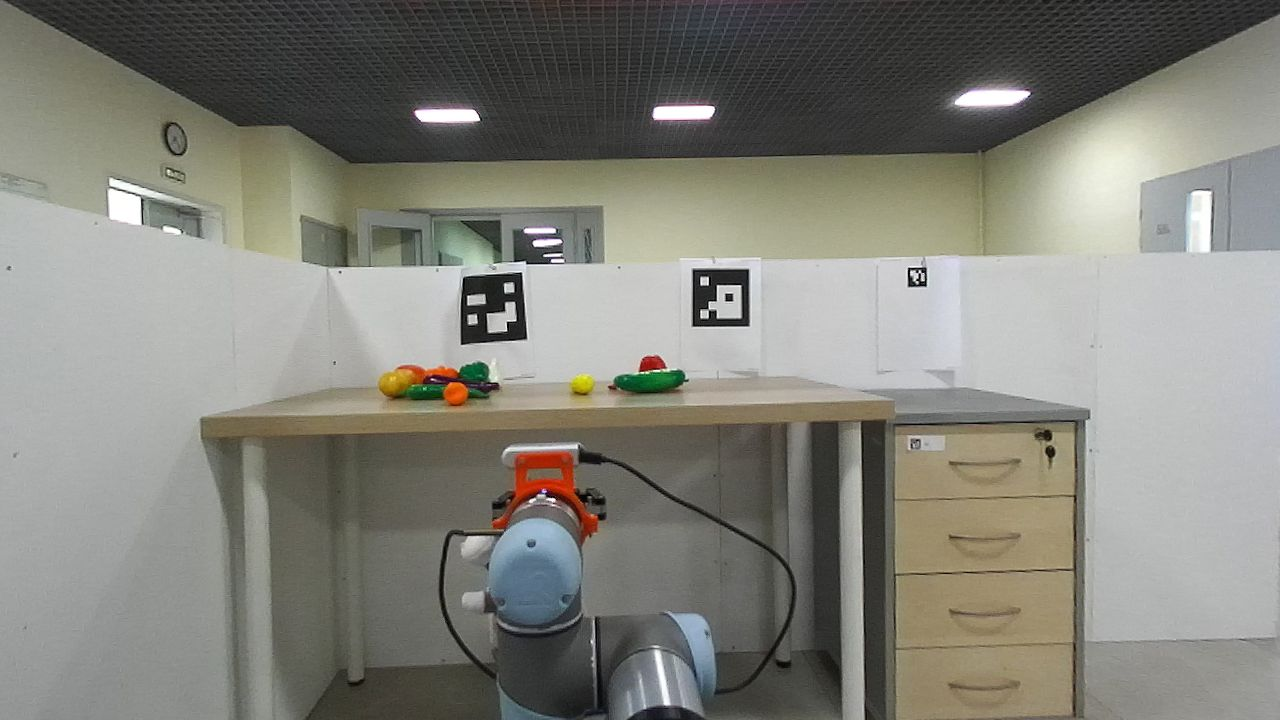

In [ ]:
# Imports PIL module  
from PIL import Image 

# open method used to open different extension image file 
im = Image.open("/data/vkarlov/robotics/train_dataset/train_images/-167436868961384133_0.png")  

# This method will show image in any image viewer  
im.show()  

In [ ]:
pred_df.iloc[-90:]

In [ ]:
pred_df['plan']

0      [[move_to, [green box, orange kitten]], [pick_...
1      [[move_to, [floor, toy cube]], [pick_up, [floo...
2      [[move_to, [table, toy cat]], [pick_up, [table...
3      [[move_to, [drawer, cucumber]], [pick_up, [tab...
4      [[move_to, [table, cucumber]], [pick_up, [tabl...
                             ...                        
225    [[move_to, [floor, tomato]], [pick_up, [floor,...
226    [[move_to, [table, cube]], [pick_up, [table, c...
227                                                   []
228    [[move_to, [table, toy cat]], [put, [table, to...
229    [[move_to, [unspecified, toy]], [pick_up, [uns...
Name: plan, Length: 230, dtype: object

# Инференс на тесте

In [21]:
class SorterDataset_TEST(Dataset):
    def __init__(self, path_to_csv: str = ""):
        with open(path_to_csv, 'r') as f:
            self._data = json.load(f)
        self._size = len(self._data)

    def __len__(self):
        return self._size

    def __getitem__(self, idx) -> SorterTask:
        entry = self._data[idx]
        steps = []
        return SorterTask(goal=entry['goal_eng'],
                        image='/data/vkarlov/robotics/test_dataset/test_images/' + entry['image'],
                        steps=steps,
                        task_type=entry['task_type'],
                        plan_id=entry["plan_id"])  

In [22]:
from torch.utils.data import DataLoader, Dataset

BATCH_SIZE_TEST = 32

path_to_csv_test = "/data/vkarlov/robotics/test_dataset/test_dataset.json"
dataset_test = SorterDataset_TEST(path_to_csv=path_to_csv_test)

dataloader_test = DataLoader(
        dataset_test,
        shuffle=False,
        batch_size=BATCH_SIZE_TEST,
        num_workers=8,
        collate_fn=lambda x: x,
        drop_last=False,
    )

In [23]:
dataset_test[0]

SorterTask(action='', image='/data/vkarlov/robotics/test_dataset/test_images/2176356811276008251_0.png', text='', goal='Put the gray cat in an orange container.', task_type=0, plan_id=0, steps=[], arguments=[])

In [24]:
processor = PromptProcessor()
# processor.build_system_prompt([dataset[i] for i in range(10)])
# print(processor._system_prompt)
gen_method = FullPlanGeneration(model, processor)

In [25]:
from typing import List

class FullPlanGeneration():
    def __init__(self,
                 model,
                 processor,
                 **kwargs):
        self._processor = processor
        self._model = model

    def predict(self, gt_task_batch: List[SorterTask]) -> List[SorterTask]:
        batch_outputs = infer_model(gt_task_batch)
        model_ouputs = [self._processor.to_task(BaseOutput(text.replace('\\', ''))) for text in batch_outputs]
        return model_ouputs

In [26]:
results_test = []

for i, batch in tqdm(enumerate(dataloader_test), total=len(dataloader_test)):
    
    batch_predict = gen_method.predict(batch)

    for elem, pred_elem in zip(batch, batch_predict):
        results_test.append(
            {
                'plan_id' : elem.plan_id,
                'image' : elem.image,
                'goal_eng' : elem.goal,
                "task_type": 0,
                'plan' : pred_elem.to_list(),
                # 'predicted_text' : pred_elem.text,
            }
        )
        
        
        
        # {"plan_id": 0, "image": "2176356811276008251_0.png", "goal_eng": "Put the gray cat in an orange container.", "task_type": 0, "plan": [["fill_this_place", ["fill_this_place", "fill_this_place"]]]}

100%|██████████| 3/3 [01:03<00:00, 21.29s/it]


In [27]:
results_test

[{'plan_id': 0,
  'image': '/data/vkarlov/robotics/test_dataset/test_images/2176356811276008251_0.png',
  'goal_eng': 'Put the gray cat in an orange container.',
  'task_type': 0,
  'plan': [['move_to', ['orange container', 'gray cat']],
   ['put', ['orange container', 'gray cat']]]},
 {'plan_id': 1,
  'image': '/data/vkarlov/robotics/test_dataset/test_images/2176356811276008251_0.png',
  'goal_eng': 'Put the toy on the floor.',
  'task_type': 0,
  'plan': [['move_to', ['floor', 'toy']], ['put', ['floor', 'toy']]]},
 {'plan_id': 2,
  'image': '/data/vkarlov/robotics/test_dataset/test_images/2556860223905553708_0.png',
  'goal_eng': 'Take the garlic from the table and put it on a chair.',
  'task_type': 0,
  'plan': [['move_to', ['table', 'garlic']],
   ['pick_up', ['table', 'garlic']],
   ['move_to', ['chair', 'garlic']],
   ['put', ['chair', 'garlic']]]},
 {'plan_id': 3,
  'image': '/data/vkarlov/robotics/test_dataset/test_images/2556860223905553708_0.png',
  'goal_eng': 'Pick up the 

In [28]:
with open('results_test4.json', 'w') as f:
    json.dump(results_test, f, indent=4)